In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error


import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

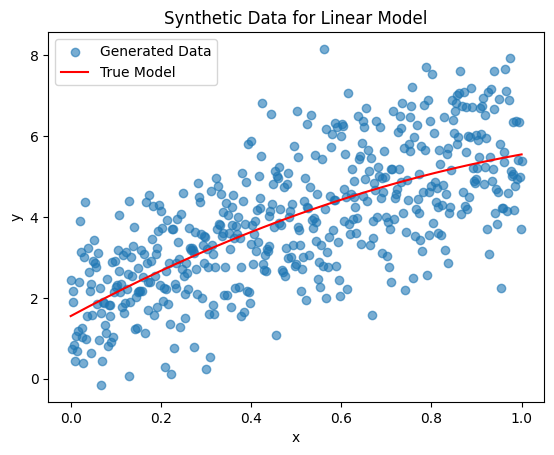

In [63]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters for our model
n_points = 500  # Number of data points
true_intercept = 1.55  # Intercept (w_0)
true_slope = 6 # Slope (w_1)
true_w2 = -2  #
true_sigma = 1  # Noise standard deviation (sigma)

# Generate synthetic data with quadratic term
x_values = np.linspace(0, 1, n_points)  # x evenly spaced
noise = np.random.normal(0, true_sigma + 0.5 * x_values, size=n_points)
y_values = true_intercept + true_slope * x_values + true_w2 * x_values**2 + noise  # Generate y with quadratic term

# Visualize the data
plt.scatter(x_values, y_values, label="Generated Data", alpha=0.6)
plt.plot(x_values, true_intercept + true_slope * x_values + true_w2 * x_values**2, color="red", label="True Model")
plt.title("Synthetic Data for Linear Model")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [120]:
with pm.Model() as bad_model:
    # Wide priors for parameters (uninformative priors)
    w0 = pm.Normal('w0', mu=0, sigma=20)  # Prior for intercept (w0)
    w1 = pm.Normal('w1', mu=0, sigma=20)  # Prior for slope (w1)
    sigma = pm.Uniform('sigma', lower=2, upper=20)  # Prior for sigma (error term)

    # Linear model (without the quadratic term)
    y_est = w0 + w1 * x_values  # Linear regression model (no quadratic term)

    # Likelihood of observing y (normal distribution with mean y_est and std sigma)
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_values)

    # Inference using No-U-Turn Sampler (NUTS)
    # Use fewer samples (e.g., 500) and fewer chains (e.g., 2)
    trace_bad = pm.sample(500, chains=2, progressbar=True)

# Check the posterior summary to see the results
az.summary(trace_bad, hdi_prob=0.95)

Output()

Output()

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.006,0.006,2.000,2.019,0.000,0.000,414.0,305.0,1.00
w0,1.885,0.167,1.537,2.191,0.008,0.006,403.0,417.0,1.00
w1,4.068,0.289,3.482,4.616,0.015,0.010,395.0,364.0,1.01


Output()

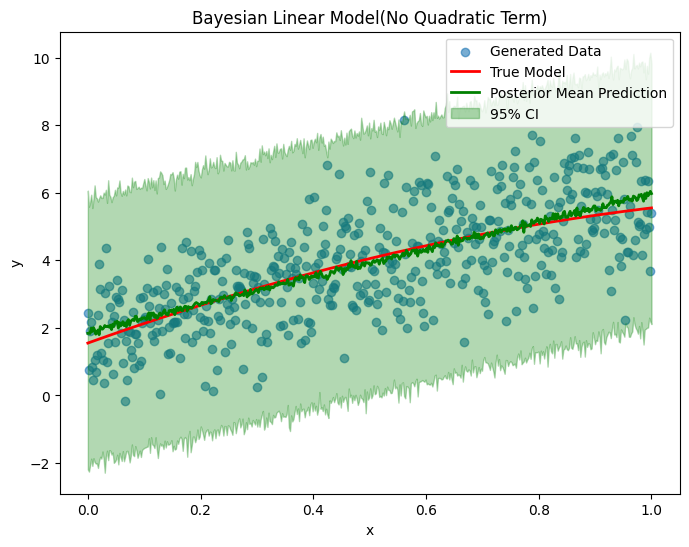

In [121]:
import pymc as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Assuming 'trace_bad' is the trace object from your sampling
# and 'bad_model' is the model used for sampling.

# Generate posterior predictive samples within the model context
with bad_model:
    posterior_predictive = pm.sample_posterior_predictive(trace_bad, var_names=["y"])


# Extract posterior predictive samples for 'y' from posterior_predictive
y_pred = posterior_predictive['posterior_predictive']['y']

# Calculate posterior mean prediction (mean over chains and draws)
y_pred_mean = y_pred.mean(axis=(0, 1))  # Mean over chains and draws

# Calculate the 95% credible interval (HDI)
y_pred_lower = np.percentile(y_pred, 2.5, axis=(0, 1))  # 2.5% percentile
y_pred_upper = np.percentile(y_pred, 97.5, axis=(0, 1))  # 97.5% percentile

# Visualizing the posterior predictions for the "bad model"
plt.figure(figsize=(8, 6))

# Plot the observed data (blue dots)
plt.scatter(x_values, y_values, label="Generated Data", alpha=0.6)

# Plot the true model (red line)
plt.plot(x_values, true_intercept + true_slope * x_values + true_w2 * x_values**2, color="red", label="True Model", linewidth=2)

# Plot the posterior mean prediction (green line)
plt.plot(x_values, y_pred_mean, color="green", label="Posterior Mean Prediction", linewidth=2)

# Plot the 95% credible interval for predictions (shaded region)
plt.fill_between(x_values, y_pred_lower, y_pred_upper, color='green', alpha=0.3, label="95% CI")

plt.title("Bayesian Linear Model(No Quadratic Term)")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()



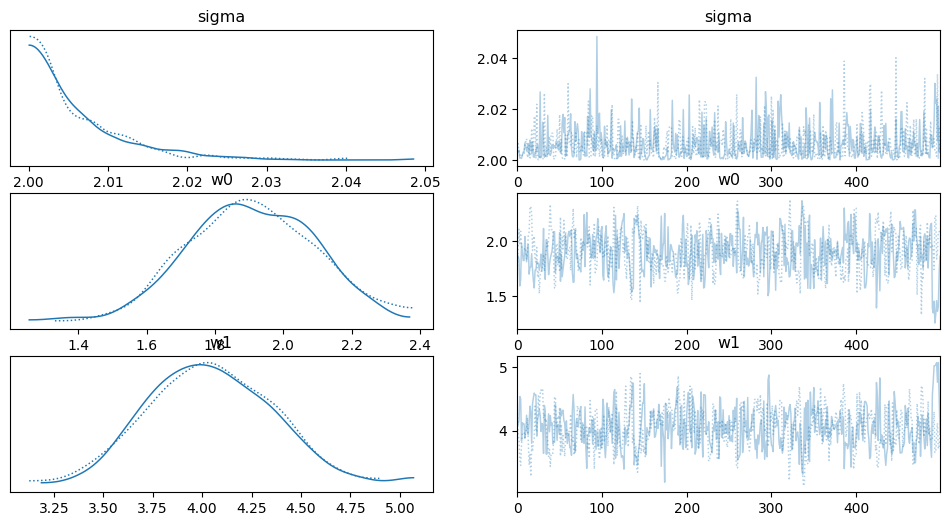

In [102]:
import arviz as az
import matplotlib.pyplot as plt

# Trace plots to check convergence of the MCMC chains
az.plot_trace(trace_bad)
plt.show()


In [135]:
# Bayesian Linear Regression model with quadratic term
num_samples = 2000  # Number of samples to draw

model = pm.Model()

with model:
    # Define priors for w0, w1, and w2 (adjusted to be closer to the true values)
    w0 = pm.Normal('w0', mu=1, sigma=5)  # Prior for intercept (w0)
    w1 = pm.Normal('w1', mu=1.5, sigma=10)     # Prior for slope (w1)
    w2 = pm.Normal('w2', mu=-0.1, sigma=20)    # Prior for quadratic coefficient (w2)
    sigma = pm.Uniform('sigma', lower=0, upper=10)  # Prior for sigma (error), between 0 and 10

    # Linear model (with quadratic term)
    y_est = w0 + w1 * x_values + w2 * x_values**2

    # Likelihood of observing y (normal distribution with mean y_est and std sigma)
    likelihood = pm.Normal('y', mu=y_est, sigma=sigma, observed=y_values)

    # Inference using the No-U-Turn Sampler (NUTS) method
    sampler = pm.NUTS()  # Hamiltonian MCMC with NUTS

    # Draw samples from the posterior (4 chains for better convergence checking)
    idata = pm.sample(num_samples, chains=4,tune = 500, step=sampler, progressbar=True)



Output()

Output()

Output()

Output()

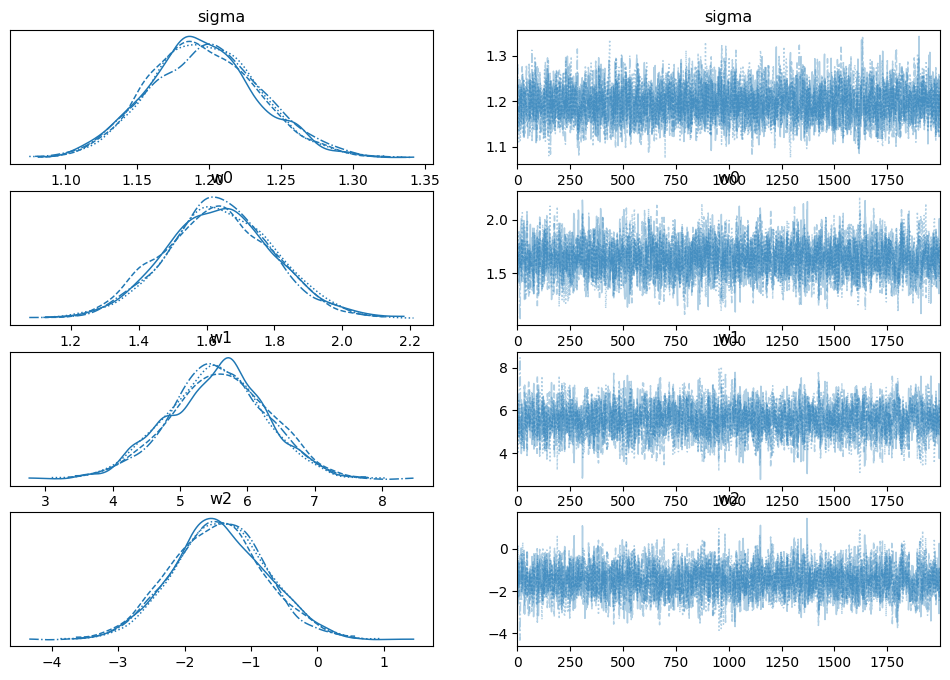

In [136]:
import arviz as az
import matplotlib.pyplot as plt

# Trace plots to check convergence of the MCMC chains
az.plot_trace(idata)
plt.show()


In [141]:
# Get a summary of the posterior distributions
az.summary(idata, hdi_prob=0.95, round_to=2)


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,1.20,0.04,1.12,1.28,0.00,0.00,3663.32,4089.08,1.0
w0,1.64,0.16,1.34,1.97,0.00,0.00,2540.41,3107.07,1.0
w1,5.56,0.74,4.15,7.02,0.02,0.01,2179.99,2139.48,1.0
w2,-1.48,0.71,-2.84,-0.06,0.01,0.01,2300.42,2601.94,1.0


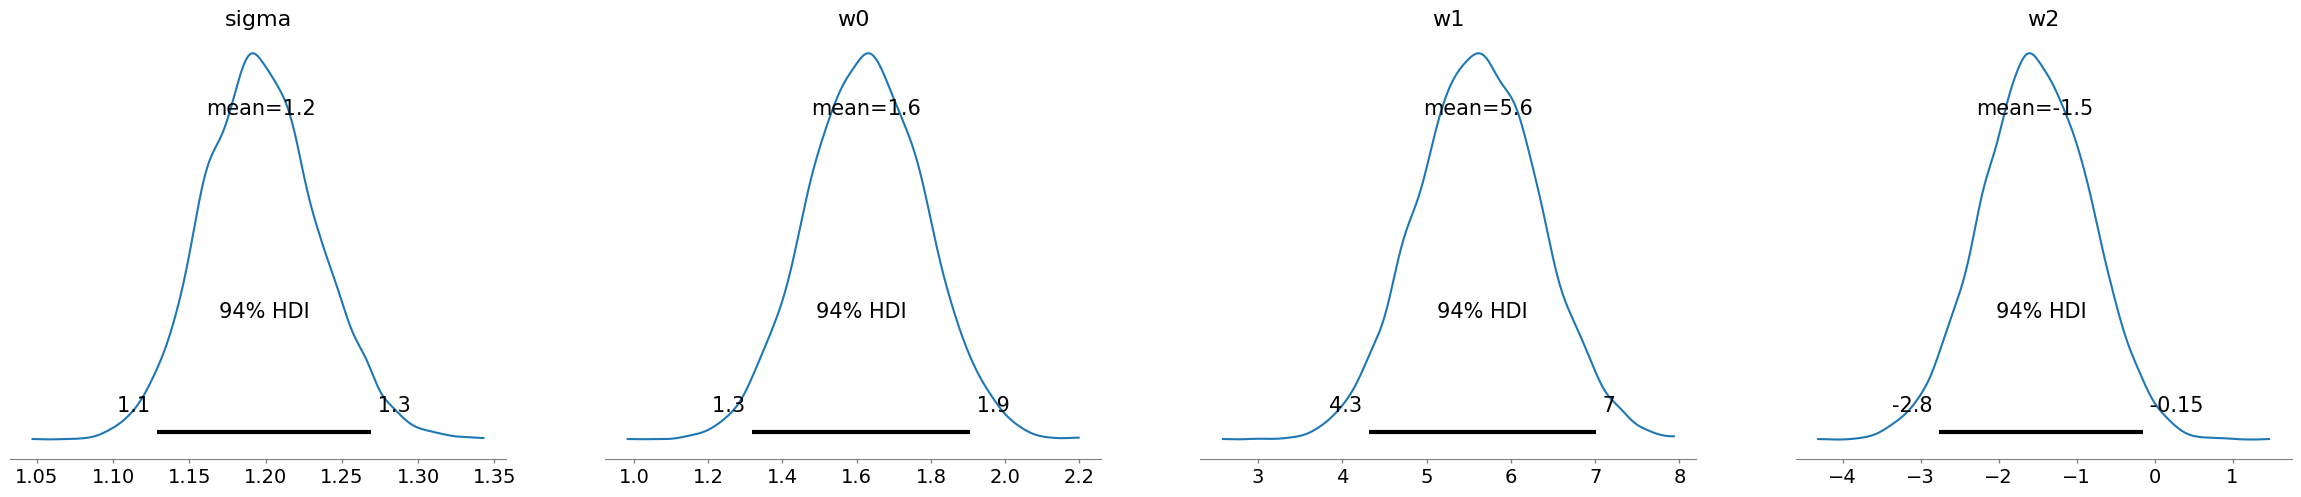

In [128]:
# Plot the posterior distributions for all parameters
az.plot_posterior(idata)
plt.show()


Output()

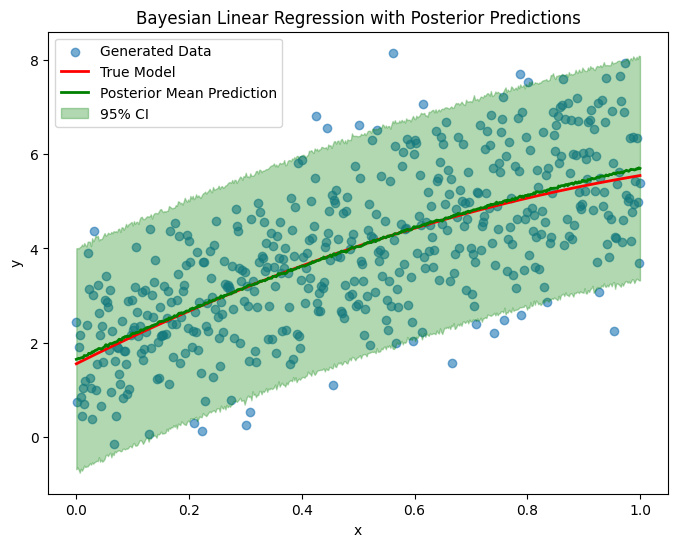

In [137]:
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

# Assuming you've already generated the posterior predictive samples from your model:
# posterior_predictive = pm.sample_posterior_predictive(idata, var_names=['y'])

# Step 1: Extract the posterior predictive samples for 'y'
with model:
    posterior_predictive = pm.sample_posterior_predictive(idata, var_names=["y"])

y_pred = posterior_predictive['posterior_predictive']['y']

# Step 2: Calculate the posterior mean prediction
y_pred_mean = y_pred.mean(axis=(0, 1))  # Mean over chains and draws

# Step 3: Calculate the 95% credible interval (HDI)
y_pred_lower = np.percentile(y_pred, 2.5, axis=(0, 1))  # 2.5% percentile
y_pred_upper = np.percentile(y_pred, 97.5, axis=(0, 1))  # 97.5% percentile

# Step 4: Visualize the posterior predictive checks
plt.figure(figsize=(8, 6))

# Plot the observed data (blue dots)
plt.scatter(x_values, y_values, label="Generated Data", alpha=0.6)

# Plot the true model (red line)
plt.plot(x_values, true_intercept + true_slope * x_values + true_w2 * x_values**2, color="red", label="True Model", linewidth=2)

# Plot the posterior mean prediction (green line)
plt.plot(x_values, y_pred_mean, color="green", label="Posterior Mean Prediction", linewidth=2)

# Plot the 95% credible interval for predictions (shaded region)
plt.fill_between(x_values, y_pred_lower, y_pred_upper, color='green', alpha=0.3, label="95% CI")

# Add labels and legend
plt.title("Bayesian Linear Regression with Posterior Predictions")
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.show()


In [122]:
import numpy as np

# Calculate the Mean Squared Error (MSE)
mse = np.mean((y_values - y_pred_mean) ** 2)

# Calculate the Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)

# Extract numeric values from the DataArray
mse_value = mse.values
rmse_value = rmse.values

print(f"Mean Squared Error (MSE): {mse_value}")
print(f"Root Mean Squared Error (RMSE): {rmse_value}")



Mean Squared Error (MSE): 1.4414359234120866
Root Mean Squared Error (RMSE): 1.2005981523441083
